1 часть

In [27]:
import os
import random
import re
import cv2
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

Напишем функцию, которая будет генерировать простое математические выражение из нашего алфавита (названий классов в наборе данных - "data").

In [47]:
def generate_expression(
    digits = ['0','1','2','3','4','5','6','7','8','9'],
    letters = ['h','w','X','y'],
    operations = ['+','-','times'],
    use_brackets = True
):
    left = random.choice(digits + letters)
    op = random.choice(operations)
    right = random.choice(digits + letters)
    
    expr = f"{left}{op}{right}"
    
    if use_brackets:
        if random.random() < 0.5:
            expr = f"({expr})"
    
    return expr


Проверим функцию генерации выражений

In [48]:
print("Примеры сгенерированных выражений:")
for _ in range(5):
    print(generate_expression())

Примеры сгенерированных выражений:
(y-6)
(5timesw)
w-8
w-3
(ytimes4)


Напишем функцию, чтобы разбить наше строчное выражение на отдельные символы, так скажем, чтобы понять, что у нас в выражении находится.
Например, у нас получилось выражение (8times3), но мы вытащим из этого "(", "8", "times", "3", ")".

In [53]:
def split_expression(expr):
    variables = []
    i = 0
    while i < len(expr):
        if expr[i:i+5] == 'times':
            variables.append('times')
            i += 5
        elif expr[i] in '()+-':
            variables.append(expr[i])
            i += 1
        elif expr[i].isdigit() or expr[i] in ['h', 'w', 'X', 'y']:
            variables.append(expr[i])
            i += 1
        else:
            print(f"Неизвестный символ в выражении: {expr[i]}")
            i += 1
    return variables


Функция для взятия изображения из каталога

In [54]:
def get_random_image_for_symbol(symbol, data_root="data"):
    folder = os.path.join(data_root, symbol)
    if not os.path.isdir(folder):
        print(f"Нет папки для символа: {symbol}")
        return None
    
    files = [f for f in os.listdir(folder) if f.endswith(".jpg")]
    if not files:
        print(f"Нет изображений в папке: {folder}")
        return None
    
    chosen = random.choice(files)
    img_path = os.path.join(folder, chosen)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    return img


Функция сборки из наших "переменных" из строчного выражения в полноценное графическое выражение

In [55]:
def build_expression_image(expression, data_root="data"):
    symbol_images = []
    tokens = split_expression(expression)

    for ch in tokens:
        img = get_random_image_for_symbol(ch, data_root)
        if img is not None:
            symbol_images.append(img)
    
    if not symbol_images:
        print("Не удалось построить изображение выражения.")
        return None
    
    h_min = min(img.shape[0] for img in symbol_images)
    resized = [cv2.resize(img, (img.shape[1], h_min)) for img in symbol_images]
    full_expr_img = np.hstack(resized)
    return full_expr_img


Функция для показа графического выражения

In [56]:
def show_expression_image(expr_img):
    plt.figure(figsize=(12, 3))
    plt.imshow(expr_img, cmap='gray')
    plt.axis('off')
    plt.title("Изображение выражения")
    plt.show()


Сгенерированное выражение: (4+7)


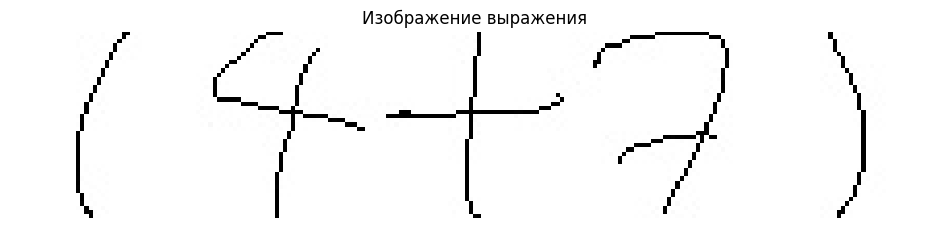

In [57]:
expr = generate_expression()
print("Сгенерированное выражение:", expr)

expr_img = build_expression_image(expr, data_root="data")
if expr_img is not None:
    show_expression_image(expr_img)


Функция загрузки изображения и извлечения из них HOG признаки

In [58]:
from skimage.feature import hog

def load_images_from_folder_hog(folder_path, label, limit=20, size=(45, 45)):
    images = []
    files = os.listdir(folder_path)
    random.shuffle(files)
    files = [f for f in files if f.endswith('.jpg')][:limit]

    for fname in files:
        path = os.path.join(folder_path, fname)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, size)
        
        features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        images.append((features, label))
    return images


In [59]:
def prepare_training_data_hog(data_root="data", limit_per_class=20):
    all_data = []
    for label in os.listdir(data_root):
        folder_path = os.path.join(data_root, label)
        if os.path.isdir(folder_path):
            samples = load_images_from_folder_hog(folder_path, label, limit=limit_per_class)
            all_data.extend(samples)

    X = np.array([x for x, _ in all_data])
    y = np.array([y for _, y in all_data])
    return X, y


Функция обучения k-NN и получения модели

In [71]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

def train_knn_classifier(X, y, n_neighbors=3):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='cosine')
    knn.fit(X, y)
    # acc = knn.score(X, y)
    # print(f"Точность на отложенной выборке: {acc:.3f}")
    return knn


Обучение и замер точности полученной модели. Я посмотрел и впринципе можно использовать небольшое количество ближайших соседей, чтобы достичь оптимальной точности в 80+- процентов.

In [74]:
X_hog, y_hog = prepare_training_data_hog(data_root="data", limit_per_class=20)

# [train_knn_classifier(X_hog, y_hog, n_neighbors=x) for x in range(1,21)]

knn_hog = train_knn_classifier(X_hog, y_hog, n_neighbors=3)
acc = knn_hog.score(X_hog, y_hog)
print(f"Точность на отложенной выборке: {acc:.3f}")

Точность на отложенной выборке: 0.817


Функция классификации изображения с символов на основе HOG-признаков

In [75]:
def classify_symbol_image_hog(knn_model, img, size=(45, 45)):
    img_resized = cv2.resize(img, size)
    features = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
    features = features.reshape(1, -1)
    pred = knn_model.predict(features)
    return pred[0]


In [76]:
def classify_expression_image(knn_model, expression, data_root="data"):
    symbols = split_expression(expression)
    predicted = []

    for symbol in symbols:
        img = get_random_image_for_symbol(symbol, data_root)
        if img is None:
            predicted.append('?')
            continue
        label = classify_symbol_image_hog(knn_model, img)
        predicted.append(label)

    return ''.join(predicted)


Сгенерированное выражение: 9-4


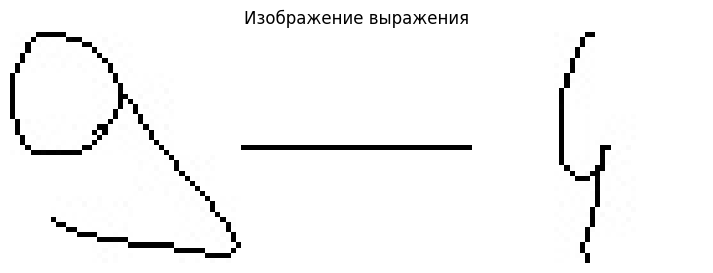

Распознанное выражение: 9-4


In [80]:
expr = generate_expression()
print("Сгенерированное выражение:", expr)

# Покажем изображение выражения
expr_img = build_expression_image(expr, data_root="data")
if expr_img is not None:
    show_expression_image(expr_img)

# Классифицируем по символам
recognized_expr = classify_expression_image(knn_hog, expr, data_root="data")
print("Распознанное выражение:", recognized_expr)


In [82]:
import re

def check_expression_regex(expr):
    pattern = re.compile(r'^\(?([0-9hwXy]+)(\+|\-|times)([0-9hwXy]+)\)?$')
    match = pattern.match(expr)

    if match:
        groups = match.groups()
        print(f"Выражение корректно: {expr}")
        print(f"    Левый операнд: {groups[0]}")
        print(f"    Операция: {groups[1]}")
        print(f"    Правый операнд: {groups[2]}")
        return True
    else:
        print(f"Выражение не прошло проверку: {expr}")
        return False


In [83]:
check_expression_regex(expr)

Выражение корректно: 9-4
    Левый операнд: 9
    Операция: -
    Правый операнд: 4


True

In [87]:
from itertools import product

def evaluate_expression(expr):
    expr_converted = expr.replace("times", "*")

    variables = [v for v in ['h', 'w', 'X', 'y'] if v in expr_converted]

    if not variables:
        try:
            result = eval(expr_converted)
            print(f"{expr_converted} = {result}")
        except Exception as e:
            print(e)
        return

    print(f"Таблица значений для выражения: {expr_converted}")
    print(" | ".join(variables) + " | result")
    print("-" * 30)

    for vals in product([0, 1], repeat=len(variables)):
        context = dict(zip(variables, vals))
        try:
            result = eval(expr_converted, {}, context)
            row = " | ".join(str(v) for v in vals) + f" | {result}"
        except Exception:
            row = " | ".join(str(v) for v in vals) + f" | error"
        print(row)


In [88]:
if check_expression_regex(expr):
    evaluate_expression(expr)

Выражение корректно: 9-4
    Левый операнд: 9
    Операция: -
    Правый операнд: 4
9-4 = 5


2 часть

In [ ]:
def load_templates(symbol='1', data_root='data', limit=3, size=(5, 5)):
    folder = os.path.join(data_root, symbol)
    files = [f for f in os.listdir(folder) if f.endswith('.jpg')]
    random.shuffle(files)
    templates = []

    for f in files[:limit]:
        path = os.path.join(folder, f)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, size)
        templates.append(img)

    return templates

In [138]:
def apply_template_matching(expr_img, templates, threshold=0.7):
    match_mask = np.zeros(expr_img.shape, dtype=np.uint8)

    for tpl in templates:
        result = cv2.matchTemplate(expr_img, tpl, cv2.TM_CCOEFF_NORMED)
        loc = np.where(result >= threshold)
        h, w = tpl.shape

        for (x, y) in zip(loc[1], loc[0]):
            match_mask[y:y+h, x:x+w] = 255

    return match_mask


In [139]:
def mask_to_binary_code(mask, patch_size=10):
    h, w = mask.shape
    code = []

    for y in range(0, h, patch_size):
        for x in range(0, w, patch_size):
            patch = mask[y:y+patch_size, x:x+patch_size]
            if (patch > 0).any():
                code.append('1')
            else:
                code.append('0')

    return ''.join(code)


In [140]:
def get_count_needed_cells(binary_code):
    import re
    return len(re.findall(r'010', binary_code))


Выражение: 9times7


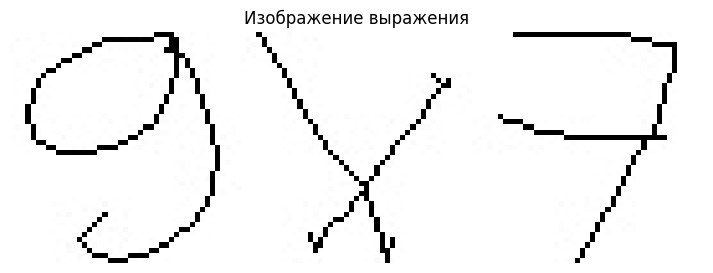

Бинарная строка: 1010111000011011100011100110001101110011101111010000110000000100001000
Отдельно стоящих символов 010: 4


In [ ]:
expr = "9times7"#generate_expression()
print("Выражение:", expr)

expr_img = build_expression_image(expr)
show_expression_image(expr_img)

templates = load_templates('1', limit=3)
mask = apply_template_matching(expr_img, templates, threshold=0.7)

binary_code = mask_to_binary_code(mask, patch_size=10)
print("Бинарная строка:", binary_code)

count = get_count_needed_cells(binary_code)
print("Отдельно стоящих символов 010:", count)


1